# Model

In [4]:
import os 
os.listdir('/kaggle/input/')

['ieee-fraud-detection']

## Load Data

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

df_train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df_train_txn = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
df_test_txn = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

df_sample = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

print("Full Train Set")
df = pd.merge(df_train_txn, df_train_id, on = 'TransactionID', how = 'left' )
df.head()


Full Train Set


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Feature Selection

In [6]:
num_cols = df.select_dtypes(include = ['int64', 'float64']).drop('isFraud', axis=1).columns.tolist()

corr_matrix = df[num_cols].sample(n=10000, random_state=42).corr(method='spearman').abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_reduced = df.drop(columns=to_drop)

print(to_drop)

print(f"Dropped {len(to_drop)} correlated features.")



['TransactionDT', 'C8', 'C10', 'D2', 'D6', 'D7', 'D12', 'V5', 'V11', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V22', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V36', 'V39', 'V40', 'V41', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V54', 'V57', 'V58', 'V59', 'V60', 'V62', 'V63', 'V64', 'V65', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V76', 'V79', 'V80', 'V81', 'V83', 'V84', 'V85', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V106', 'V119', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V140', 'V142', 'V145', 'V147', 'V149', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V168', 'V171', 'V175', 'V178', 'V179', 'V182', 'V183', 'V185', 'V189', 'V192', 'V193', 'V195', 'V197', 'V198', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V219', 'V222', 'V230', 'V233', 'V23

## Split 

In [7]:
from sklearn.model_selection import train_test_split

X = df_reduced.drop('isFraud', axis = 1)
y = df_reduced['isFraud']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y , test_size = 0.2, random_state = 42, stratify = y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp , test_size = 0.25, random_state = 42, stratify = y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (354324, 237) (354324,)
Validation: (118108, 237) (118108,)
Test: (118108, 237) (118108,)


## Feature Based on Skewness

In [8]:
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_cols = X_train.select_dtypes(include = ['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include =['object']).columns.tolist()

skews = X_train[num_cols].apply(lambda x: x.skew(skipna=True)).fillna(0)

normal_features = skews[abs(skews) < 1].index.tolist()        
moderate_features = skews[(abs(skews) >= 1) & (abs(skews) < 5)].index.tolist()   
heavy_features = skews[abs(skews) >= 5].index.tolist()      

print(f"Normal features: {len(normal_features)}")
print(f"Moderate features: {len(moderate_features)}")
print(f"Heavy features: {len(heavy_features)}")


Normal features: 24
Moderate features: 36
Heavy features: 146


# Preprocessing Pipeline

## Capping Moderate Feature

In [9]:
for col in moderate_features:
    lower, upper = X_train[col].quantile([0.01, 0.99])
    X_train[col] = X_train[col].clip(lower, upper)

In [10]:
def make_preprocessor(model_name):
    standard_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    robust_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    power_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
        ('scaler', RobustScaler())
    ])

    cat_pipe_tree = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    cat_pipe_target = Pipeline([
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('encoder', TargetEncoder())
    ])

    if model_name in ['LogisticRegression', 'SVM(RBF)', 'KNN', 'NaiveBayes']:
        cat_pipe = cat_pipe_target
    else:
        cat_pipe = cat_pipe_tree

    preprocessor = ColumnTransformer([
        ('standard', standard_pipe, normal_features),
        ('robust', robust_pipe, moderate_features),
        ('power', power_pipe, heavy_features),
        ('cat', cat_pipe, cat_cols)
    ], remainder='drop', sparse_threshold=0)  

    return preprocessor
    
print("\nSkew summary before transformations:")
print(skews.describe())



Skew summary before transformations:
count    206.000000
mean      14.770078
std       36.160000
min     -130.205432
25%        2.305533
50%        9.465026
75%       20.960970
max      420.899632
dtype: float64


In [12]:
# preprocessor.fit(X_train)

# X_train_transf = preprocessor.transform(X_train)
# X_val_transf = preprocessor.transform(X_val)

# print("Transformed shapes:", X_train_transf.shape, X_val_transf.shape)

# print("Any NaNs?", np.isnan(X_train_transf).any(), np.isnan(X_val_transf).any())
# print("Any infs?", np.isinf(X_train_transf).any(), np.isinf(X_val_transf).any())
# print("Max absolute value:", np.max(np.abs(X_train_transf)))



 LogisticRegression
Accuracy: 0.9648 | F1: 0.2863 | ROC-AUC: 0.5927


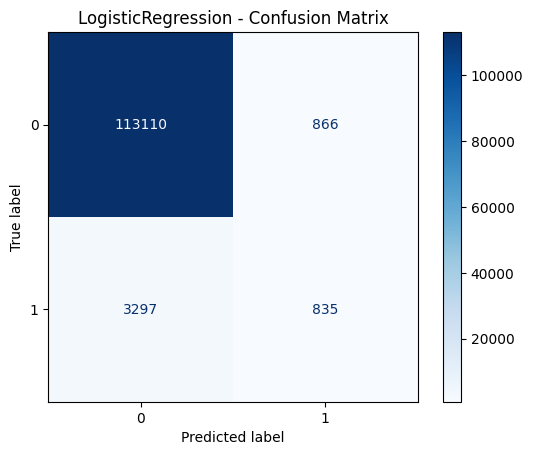


 RandomForest
Accuracy: 0.9794 | F1: 0.5990 | ROC-AUC: 0.9323


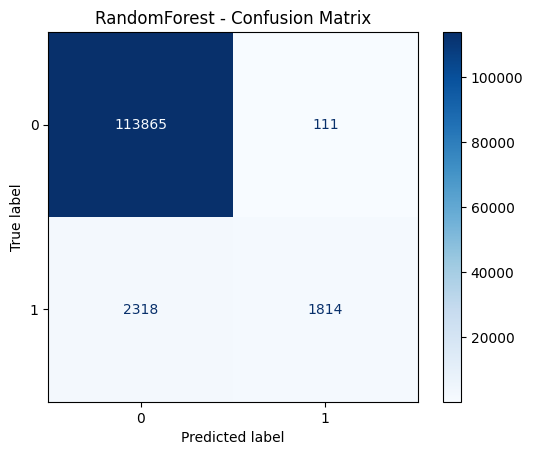


 GradientBoosting
Accuracy: 0.9740 | F1: 0.4482 | ROC-AUC: 0.8759


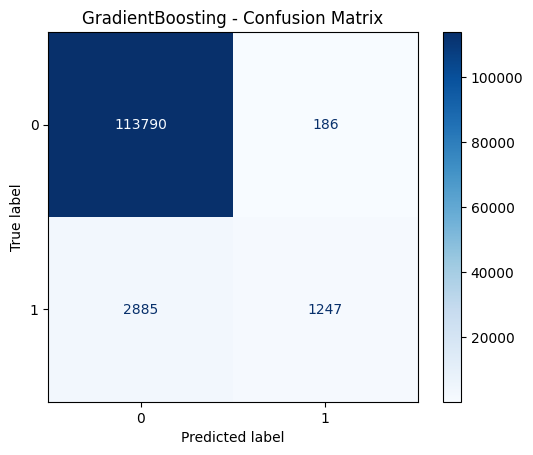


 AdaBoost
Accuracy: 0.9716 | F1: 0.3827 | ROC-AUC: 0.8685


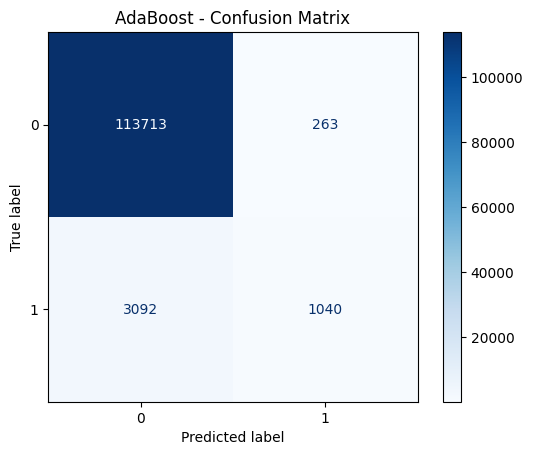

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import joblib


models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM (RBF)': SVC(probability=True, random_state=42),
    'NaiveBayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(
        random_state=42, eval_metric='logloss', use_label_encoder=False,
        tree_method='hist', n_estimators=300
    )
}

results = []

for name, model in models.items():
    preprocessor = make_preprocessor(name)
    clf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    clf_pipe.fit(X_train, y_train)
    y_val_pred = clf_pipe.predict(X_val)
    y_val_proba = clf_pipe.predict_proba(X_val)[:, 1] if hasattr(clf_pipe[-1], 'predict_proba') else y_val_pred

    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_proba)

    print(f"\n {name}")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}")

    cm = confusion_matrix(y_val, y_val_pred)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues', values_format='d')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    results.append({'model': name, 'val_accuracy': acc, 'val_f1': f1, 'val_auc': auc})
    OUTPUT_DIR = "/kaggle/working/"
    joblib.dump(clf_pipe, os.path.join(OUTPUT_DIR, f"{name}_pipeline.joblib"))

results_df = pd.DataFrame(results).sort_values(by='val_auc', ascending=False)
print("\n Final Results:")
print(results_df)


